In [1]:
# Import libraries
import matplotlib.pyplot as plt
import csv
from math import log
from math import exp

# Chargement des données

In [2]:
def loadData(filename):
    """
    Charge les données d'un fichier CSV
    """
    with open(filename, newline='') as csvfile:
        tons = {}
        data = csv.reader(csvfile, delimiter=',', quotechar='#')
        header = next(data)
        sources = next(data)
        for row in data:
            tons[int(row[0])] = int(row[1])

        X = list(tons.keys())
        Y = list(tons.values())

        return {'X':X, 'Y':Y}

In [3]:
data = loadData('global.1751_2014.csv')     # charger les données en mémoire
X = data['X']       # liste contenant toutes les années d'observation, ordonnée
Y = data['Y']       # liste contenant toutes observations, alignées sur X

## Filtrer les données

Pour étudier l'évolution des émissions il est nécessaire de pouvoir analyser les
données mises à notre disposition sur une période de temps limitée.

In [4]:
def donneesPeriode(X, Y, debut, fin):
    """
    X: années du jeu de données
    Y: emission du jeu de données
    debut: date de début des données à extraire
    fin: date de fin des données à extraire
    """
    nb_mesures = fin - debut + 1                # nombre de mesures à extraire

    index_initial = debut - X[0]                # index de la première mesure
    index_final = index_initial + nb_mesures    # index de la dernière mesure

    X_ = X[index_initial:index_final]           # garder les x sur l'intervalle 
    Y_ = Y[index_initial:index_final]           # garder les y sur l'intervalle

    return X_, Y_                               # retourner les x et les y

# Representation des données de manière graphique

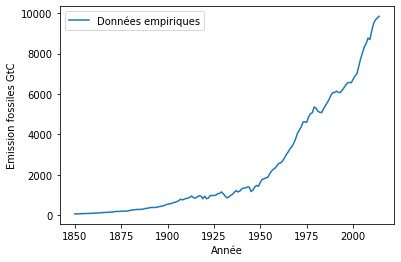

In [5]:
plt.plot(X, Y, label='Données empiriques')
plt.xlabel('Année')
plt.ylabel('Emission fossiles GtC')
plt.legend()

# Modélisation

## Modèle de croissance exponentielle
Le modèle exponentiel prend un taux de croissance et une valeur initiale.

La valeur au bout de _n_ itérations se calcule selon la formule générale _y_n = C^n * y_0_

Sur base d'un modèle de croissance exponentielle, trouver la valeur _y_ au bout de
 _n_ années depuis le début des mesures.

In [6]:
def modeleExponentiel(croissance, y0, n):
    """
    croissance: taux de croissance annuel exprimé en %
    y0: valeur initiale
    n: itération à laquelle prévoir la valeur
    """
    C = 1.0 + (croissance / 100.0)  # facteur de croissance

    yn = (C ** n) * y0              # valeur au bout de n années

    return yn                       # retourner la valeur après n années

## Estimation du taux de croissance annuelle
Estimation du taux de croissance annuel en supposant une evolution exponentielle
des émissions.

Utiliser un ajustement de courbe pour déterminer les paramètres du modèle de
croissance exponentielle.

In [7]:
def parametresModeleExponentiel(X, Y):
    """
    X: _x_ connus
    Y: _y_ connus
    """
    x0 = X[0]                       # première année de mesures
    y0 = Y[0]                       # valeur des émissions lors de cette année

    xn = X[len(X) - 1]              # dernière année de mesures
    yn = Y[len(X) - 1]              # valeur des émissions lors de cette année

    nb_annees = xn - x0             # nombre d'années de mesures

    C = (yn / y0)**(1.0/nb_annees)  # facteur de croissance
    
    croissance = (C - 1) * 100.0    # taux de croissance annuel en %

    return y0, croissance           # retourner la valeur initiale et le taux

Calculer le modèle sur un interval défini

In [8]:
def parametresModeleExponentielPeriode(X, Y, debut, fin):
    """
    X: données brutes
    Y: données brutes
    debut: date de debut de l'intervalle d'analyse
    fin: date de fin de l'intervalle d'analyse
    """
    X_, Y_ = donneesPeriode(X, Y, debut, fin)   # données sur l'intervalle

    # obtenir les parametres de l'exponentielle
    y0, croissance = parametresModeleExponentiel (X_, Y_) 

    # calculer toutes les émissions dans l'intervalle de temps grace au modèle
    # exponentiel
    Y_modele = [modeleExponentiel(croissance, y0, i) for i in range(len(X_))]
    
    return X_, Y_, Y_modele, croissance # retourner les données calculées

## Taux de croissance sur l'ensemble des données

### Calcul du taux de croissance sur différents intervalles de temps
1. l'entiereté des données
2. la période [1850, 1913]
3. la période [1945, 1973]

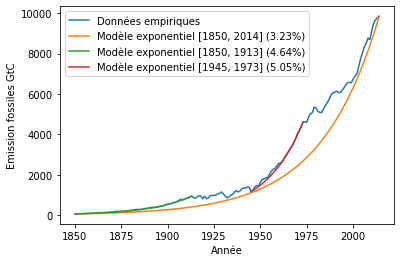

In [9]:
plt.plot(X, Y, label='Données empiriques')  # afficher les données sous forme de
                                            # graphe
plt.xlabel('Année')                         # nommer l'axe des x
plt.ylabel('Emission fossiles GtC')         # nommer l'axe des y

periodes = [
    (X[0], X[len(X)-1]),                    # l'entiereté des données
    (1850, 1913),                           # [1850, 1913]
    (1945, 1973)                            # [1945, 1973]
    ]                                       # lister les # intervalles à étudier

croissances = dict()                        # taux de croissance calculés pour
                                            # chaque période
                                            #   clé = période
                                            #   valeur = taux de croissance

# représenter graphiquement les résultats pour tous les intervalles de temps et
# mémoriser le taux de croissance annuel
for debut, fin in periodes:
    # calculer les parametres du modèle sur l'intervalle de temps
    X_, Y_, Y_modele, croissance = parametresModeleExponentielPeriode(X, Y, debut, fin)

    # mémoriser le taux de croissance
    croissances[(debut, fin)] = croissance

    # ajouter la courbe à la figure
    plt.plot(X_, Y_modele,
             label='Modèle exponentiel [{debut}, {fin}] ({croissance:.2f}%)'
                    .format(debut=debut, fin=fin, croissance=croissance))

plt.legend()

# Quel est le temps de doublement?

Astuce:
* Produit: log(M * N) = log(M) + log(N)
* Quotient: log (M/N) = log(M) - log (N)
* Puissance: log(M^p) = p * log(M)
pour M > 0 et N > 0

In [10]:
def temps_doublement(croissance):
    C = 1.0 + (croissance / 100.0)      # facteur de croissance

    temps = log(2) / log (C)            # calcul du temps de doublement

    return temps                        # retourner le temps de doublement

In [11]:
doublements = dict()    # temps de doublement calculés pour chaque période
                        #   clé = période
                        #   valeur = temps de doublement

for (periode, value) in croissances.items():
    # calculer le temps de doublement (en années entières)
    temps = int(temps_doublement(croissances[periode]))

    # mémorier le temps de doublement
    doublements[periode] = temps

    # afficher le temps de doublement
    print ("Temps de doublement pour la période [{debut}, {fin}]: {temps} années"
          .format(debut=periode[0], fin=periode[1], temps = temps))

Temps de doublement pour la période [1850, 2014]: 21 années
Temps de doublement pour la période [1850, 1913]: 15 années
Temps de doublement pour la période [1945, 1973]: 14 années


## Validation des valeurs obtenues

Comparaison avec les données brutes

In [12]:
periode = periodes[0]               # période depuis le début des données
(debut, fin) = periode              # années de début et fin de la période

fin_periode_double = fin            # fin de la dernière période de doublement
debut_periode_double = fin - doublements[periode] # début de la dernière période
                                                  # de doublement

# obtention des données sur la dernière période de doublement
X_periode_double, Y_period_double = donneesPeriode(X, Y, debut_periode_double, fin_periode_double)

y_debut_periode = Y_period_double[0]                        # emissions au début
                                                            # de la période
y_fin_periode = Y_period_double[len(Y_period_double) - 1]   # émissions à la fin
                                                            # de la période

# afficher le rapport entre les émissions de la période 
print (y_fin_periode / y_debut_periode)

1.6235584843492588


Comparaison avec le modèle

In [13]:
croissance = croissances[periode]   # récupérer le taux de croissance sur la
                                    # période

n_debut_periode_double = debut_periode_double - debut # nombre d'années écoulées
                                                      # entre le début des
                                                      # mesures et le début de
                                                      # la dernière période de
                                                      # doublement
n_fin_periode_double = fin_periode_double - debut     # nombre d'années écoulées
                                                      # entre le début des
                                                      # mesures et la fin de la
                                                      # dernière période de
                                                      # doublement

y_debut_periode_modele = modeleExponentiel(croissance, Y[0], n_debut_periode_double) # calculer la valeur de l'expontentielle au début de la dernière période de doublement
y_fin_periode_modele = modeleExponentiel(croissance, Y[0], n_fin_periode_double)     # calculer la valeur de l'expontentielle à la fin de la dernière période de doublement


# afficher le rapport entre les émission de la période
print (y_fin_periode_modele / y_debut_periode_modele)

1.947834046702566


### Mesurer le cumul des émissions depuis le début des données

In [14]:
emissions_periode_double = sum(Y_period_double)     # calculer la somme des
                                                    # émissions sur la dernière
                                                    # période de doublement

# obtention des données sur la période avant la période de doublement
X_avant, Y_avant = donneesPeriode(X, Y, debut, debut_periode_double - 1)

emissions_avant = sum(Y_avant)      # calculer la somme des émissions sur la
                                    # période avant la dernière période de
                                    # doublement


print (emissions_avant)

emissions_periode_double/emissions_avant


170715
230099


0.7419197823545517

In [15]:
# depuis le début des mesures

avant = sum ([modeleExponentiel(croissance, Y[0], n) for n in range(debut - debut, debut_periode_double - debut)])
maintenant = sum ([modeleExponentiel(croissance, Y[0], n) for n in range(debut_periode_double - debut, fin_periode_double - debut)])
maintenant / avant

0.9580594761071002